In [1]:
import pyerrors as pe
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('./base_style.mplstyle')
plt.rc('text', usetex=True)

Read data from the pcac example

In [3]:
fP = pe.Corr(pe.input.json.load_json("./data/f_P"), padding_front=1, padding_back=1)

Data has been written using pyerrors 2.0.0.
Format version 0.1
Written by fjosw on 2022-01-06 11:27:34 +0100 on host XPS139305, Linux-5.11.0-44-generic-x86_64-with-glibc2.29

Description:  SF correlation function f_P on a test ensemble


We can now define a custom fit function, in this case a single exponential. __Here we need to use the autograd wrapped version of numpy__  (imported as anp) to use automatic differentiation.

In [4]:
import autograd.numpy as anp
def func_exp(a, x):
    y = a[1] * anp.exp(-a[0] * x)
    return y

Fit single exponential to f_P. The kwarg `resplot` generates a figure which visualizes the fit with residuals.

Fit with 2 parameters
Method: Levenberg-Marquardt
`xtol` termination condition is satisfied.
chisquare/d.o.f.: 0.0023324250917749687

 Goodness of fit:
χ²/d.o.f. = 0.002332
Fit parameters:
0	 0.2036(92)
1	 16.3(1.3)



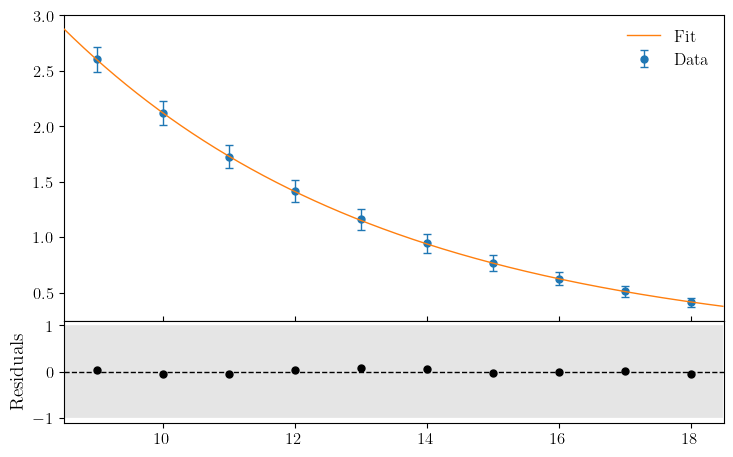

In [5]:
start_fit = 9
stop_fit = 18

fit_result = fP.fit(func_exp, [start_fit, stop_fit], resplot=True)
print("\n", fit_result)

The covariance of the two fit parameters can be computed in the following way

In [6]:
cov_01 = pe.fits.covariance(fit_result[0], fit_result[1])
print('Covariance: ', cov_01)
print('Normalized covariance: ', cov_01 / fit_result[0].dvalue / fit_result[1].dvalue)

Covariance:  0.009831165592706342
Normalized covariance:  0.8384671239654656


## Effective mass

Calculate the effective mass for comparison

In [7]:
m_eff_fP = fP.m_eff()
m_eff_fP.tag = r"Effective mass of f_P"

Calculate the corresponding plateau and compare the two results

In [8]:
m_eff_plateau = m_eff_fP.plateau([start_fit, stop_fit])
m_eff_plateau.gamma_method()
print()
print('Effective mass:\t', m_eff_plateau)
print('Fitted mass:\t', fit_result[0])

Fit with 1 parameters
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 0.13241808096937788

Effective mass:	 0.2057(68)
Fitted mass:	 0.2036(92)


We can now visualize the effective mass compared to the result of the fit

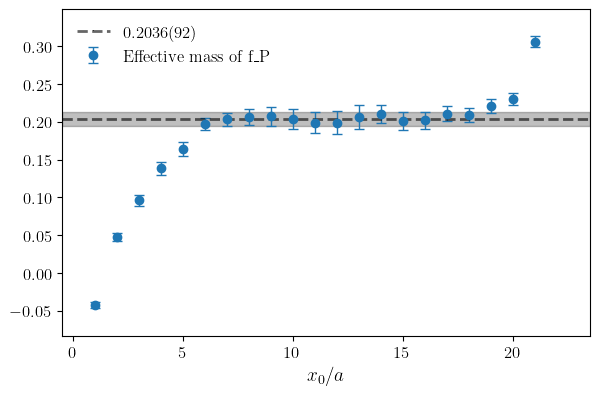

In [9]:
m_eff_fP.show(plateau=fit_result[0])

## Fitting with x-errors

We first generate pseudo data

In [10]:
ox = []
oy = []
for i in range(0,10,2):
    ox.append(pe.pseudo_Obs(i + 0.35 * np.random.normal(), 0.35, str(i)))
    oy.append(pe.pseudo_Obs(np.sin(i) + 0.25 * np.random.normal() - 0.2 * i + 0.17, 0.25, str(i)))

[o.gamma_method() for o in ox + oy]
[print(o) for o in zip(ox, oy)];

(Obs[0.57(35)], Obs[0.49(25)])
(Obs[2.53(35)], Obs[0.56(25)])
(Obs[4.17(35)], Obs[-1.52(25)])
(Obs[5.97(35)], Obs[-1.40(25)])
(Obs[7.82(35)], Obs[-0.58(25)])


And choose a function to fit

In [11]:
def func(a, x):
    y = a[0] + a[1] * x + a[2] * anp.sin(x)
    return y

We can then fit this function to the data and get the fit parameter as Obs with the function `odr_fit` which uses orthogonal distance regression.

In [12]:
beta = pe.fits.odr_fit(ox, oy, func)

for i, item in enumerate(beta):
    item.gamma_method()
    print('Parameter', i + 1, ':', item)

Fit with 3 parameters
Method: ODR
Sum of squares convergence
Residual variance: 0.4144435658518591
Parameter 1 : 0.26(28)
Parameter 2 : -0.228(53)
Parameter 3 : 0.98(22)


For the visulization we determine the value of the fit function in a range of x values

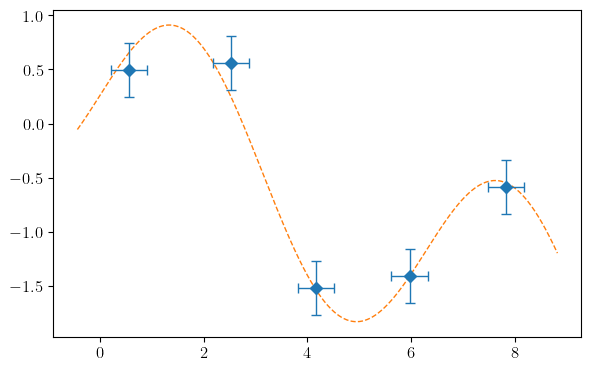

In [13]:
x_t = np.arange(min(ox).value - 1, max(ox).value + 1, 0.01)
y_t = func([o.value for o in beta], x_t)

plt.errorbar([e.value for e in ox], [e.value for e in oy], xerr=[e.dvalue for e in ox], yerr=[e.dvalue for e in oy], marker='D', lw=1, ls='none', zorder=10)
plt.plot(x_t, y_t, '--')
plt.show()

We can also take a look at how much the inidividual ensembles contribute to the uncetainty of the fit parameters

Parameter 0

Parameter 1

Parameter 2



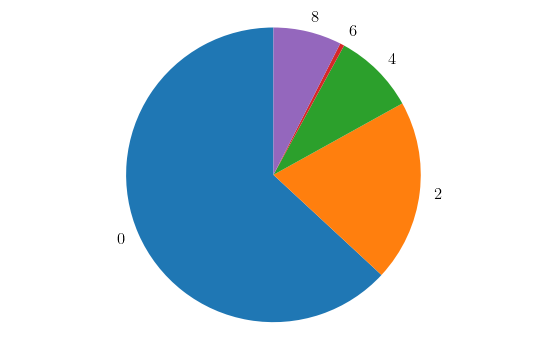

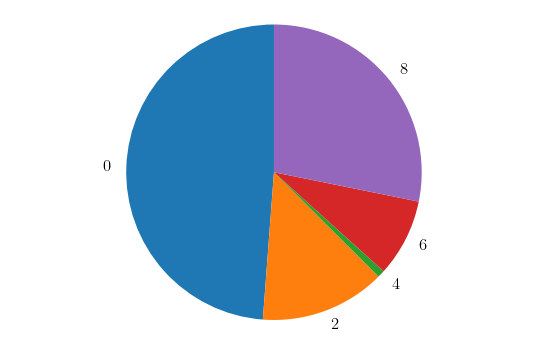

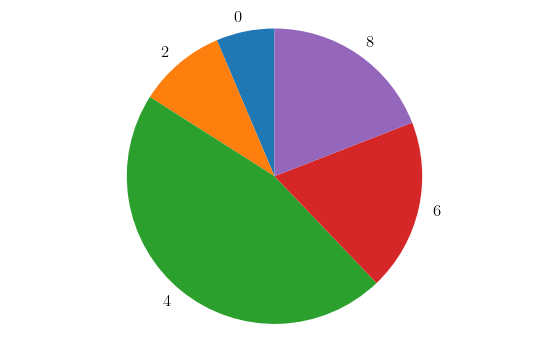

In [14]:
for i, item in enumerate(beta):
    print('Parameter', i)
    item.plot_piechart()
    print()